Improting the required libraries

In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from numpy import nan

# EDA begins

In [2]:
df_blood = pd.read_csv('blood-glucose-data.csv')
# df_blood['point_timestamp'] = pd.to_datetime(df_blood['point_timestamp'])  
# mask = (df_blood['point_timestamp'] > '2017-5-18') & (df_blood['point_timestamp'] <= '2017-7-13')
# df_blood = df_blood.loc[mask]
# df_blood['point_timestamp'] = df_blood['point_timestamp'].dt.floor('T')
# df_blood['point_timestamp'] = df_blood['point_timestamp'].dt.floor('Min')
len(df_blood)

14702

In [3]:
df_blood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14702 entries, 0 to 14701
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   point_value(mg/dL)  14702 non-null  int64 
 1   point_timestamp     14702 non-null  object
 2   timezone_offset     14702 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 344.7+ KB


In [4]:
df_blood.head()

,point_value(mg/dL),point_timestamp,timezone_offset
0,142,2017-05-15 07:51:22,-700
1,140,2017-05-15 07:56:23,-700
2,138,2017-05-15 08:01:22,-700
3,136,2017-05-15 08:06:22,-700
4,130,2017-05-15 08:11:23,-700


In [5]:
df_blood.tail()

,point_value(mg/dL),point_timestamp,timezone_offset
14697,216,2017-07-15 07:29:50,-700
14698,220,2017-07-15 07:34:51,-700
14699,220,2017-07-15 07:39:50,-700
14700,223,2017-07-15 07:44:50,-700
14701,225,2017-07-15 07:49:50,-700


In [6]:
df_blood.dtypes

point_value(mg/dL)     int64
point_timestamp       object
timezone_offset        int64
dtype: object

In [7]:
df_blood.isnull().values.any()

False

<AxesSubplot:>

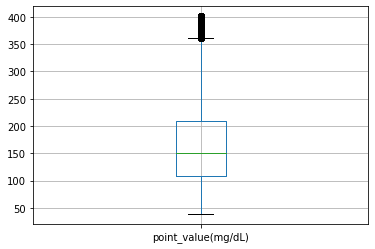

In [8]:
df_blood.boxplot(column=["point_value(mg/dL)"])

<AxesSubplot:ylabel='Frequency'>

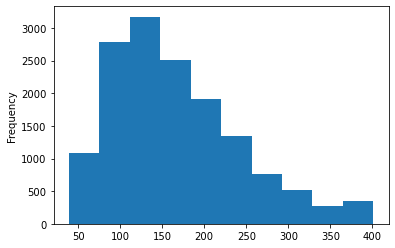

In [9]:
df_blood["point_value(mg/dL)"].plot.hist()

# Checking the number of missing datetime entries.

In [19]:
from datetime import datetime
current = 0
counter = 0

days = pd.DataFrame (columns = ['datetime','missing'])
largest_sample = 0
start = None
end = None 
for i in df_blood["point_timestamp"]:
    i = pd.to_datetime(i)
    if(current == 0):
        current = i
        continue
        
    while(i > current + pd.to_timedelta(5.5,unit='m')):
        counter += 1
        current = current + pd.to_timedelta(5,unit='m')
        #if(current.date() not in days.datetime):
        days.loc[len(days)] = [current, 1]  # adding a row
        if(counter > 1):
            date2 = datetime.strptime(str(days.loc[counter-1, "datetime"]) , '%Y-%m-%d %H:%M:%S')
            date1 = datetime.strptime(str(days.loc[counter-2, "datetime"]), '%Y-%m-%d %H:%M:%S')

            if(date2.timestamp() - date1.timestamp() > largest_sample):
                largest_sample = date2.timestamp() - date1.timestamp()
                start = days.loc[counter-2, "datetime"]
                end = days.loc[counter-1, "datetime"]
    

    current = i
    
print("no missing times", counter, " | ", (counter/(len(df_blood)+counter))*100,"%")
print("no impacted days", len(days))
print(days)
days.to_csv("missing.csv")
print (start, "--" , end)
days.info()

no missing times 2868  |  16.323278315310187 %
no impacted days 2868
                datetime missing
0    2017-05-16 00:41:21       1
1    2017-05-16 00:46:21       1
2    2017-05-16 00:51:21       1
3    2017-05-16 00:56:21       1
4    2017-05-16 01:01:21       1
...                  ...     ...
2863 2017-07-10 04:50:13       1
2864 2017-07-10 04:55:13       1
2865 2017-07-10 05:00:13       1
2866 2017-07-13 18:19:57       1
2867 2017-07-13 18:24:57       1

[2868 rows x 2 columns]
2017-05-25 15:23:07 -- 2017-05-30 05:17:49
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2868 entries, 0 to 2867
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  2868 non-null   datetime64[ns]
 1   missing   2868 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 147.2+ KB


In [21]:
df_blood['point_timestamp'] = pd.to_datetime(df_blood['point_timestamp'])
df_blood['hour'] = df_blood['point_timestamp'].dt.hour
df_blood['minute'] = df_blood['point_timestamp'].dt.minute
df_blood['day'] = df_blood['point_timestamp'].dt.day
df_blood['month'] = df_blood['point_timestamp'].dt.month
df_blood = df_blood.rename(columns={'point_value(mg/dL)': 'sugar'})

In [22]:
del df_blood['point_timestamp']
del df_blood['timezone_offset']
df_blood.head()

,sugar,hour,minute,day,month
0,142,7,51,15,5
1,140,7,56,15,5
2,138,8,1,15,5
3,136,8,6,15,5
4,130,8,11,15,5


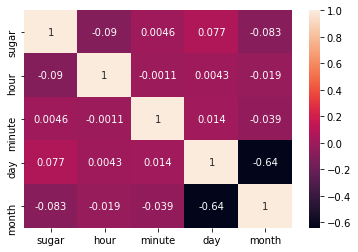

In [23]:
import seaborn as sn
s = df_blood.corr()
sn.heatmap(s, annot=True)
plt.show()

In [25]:
df_heart = pd.read_csv('heart-rate-data.csv')
df_heart['point_timestamp'] = pd.to_datetime(df_heart['point_timestamp'])  
df_heart['point_timestamp'] = df_heart['point_timestamp'].dt.floor('T')
df_heart['point_timestamp'] = df_heart['point_timestamp'].dt.floor('Min')

In [27]:
#ids = df_m["point_timestamp"]
#df_m[ids.isin(ids[ids.duplicated()])].sort_values("point_timestamp")

In [28]:
#df_m.head()

In [29]:
#df_m.tail()

In [30]:
from datetime import date, datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    if not isinstance(delta, timedelta):
        delta = timedelta(**delta)
    while current < end:
        yield current
        current += delta


start = datetime(2017,5,18, 0, 3)
end = datetime(2017,7,13)
arr = []
#this unlocks the following interface:
for dt in datetime_range(start, end, {'minutes':5}):
    arr.append(dt)
len(arr)

16128

In [31]:
#Set Parameters
training_split = 2 * 7 * 288 #training set for 2 weeks
validation_split = 6 * 288 # validation for 6 days
testing_split = 5 * 7 * 288 # testing for 5 weeks

In [33]:
#Construct data sets
training_set = df_blood.iloc[0:training_split].values
validation_set = df_blood.iloc[training_split:validation_split].values
test_set = df_blood.iloc[validation_split:testing_split].values

In [34]:
training_set[0:1, 0]

array([142], dtype=int64)

In [35]:
lag = 12
# Creating a data structure with 12 readings and 1 output
X_train = []
y_train = []
for i in range(lag+lag, len(training_set)-lag):
    X_train.append(training_set[i-lag:i, 0])
    y_train.append(training_set[i+lag, 0])
X_train, y_train = np.array(X_train).astype('float32'), np.array(y_train).astype('float32')

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [36]:
model = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# # Adding a second LSTM layer and some Dropout regularisation
# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 200, batch_size = 32)

Epoch 1/200
125/125 [==============================] - 6s 10ms/step - loss: 35797.9157 - accuracy: 0.0000e+00
Epoch 2/200
125/125 [==============================] - 1s 10ms/step - loss: 31088.4841 - accuracy: 0.0000e+00
Epoch 3/200
125/125 [==============================] - 1s 10ms/step - loss: 29524.1716 - accuracy: 0.0000e+00
Epoch 4/200
125/125 [==============================] - 1s 10ms/step - loss: 27178.1079 - accuracy: 0.0000e+00
Epoch 5/200
125/125 [==============================] - 1s 10ms/step - loss: 26465.4291 - accuracy: 0.0000e+00
Epoch 6/200
125/125 [==============================] - 1s 10ms/step - loss: 24427.6892 - accuracy: 0.0000e+00
Epoch 7/200
125/125 [==============================] - 1s 10ms/step - loss: 22271.0863 - accuracy: 0.0000e+00
Epoch 8/200
125/125 [==============================] - 1s 10ms/step - loss: 21228.2044 - accuracy: 0.0000e+00
Epoch 9/200
125/125 [==============================] - 1s 10ms/step - loss: 20347.1751 - accuracy: 0.0000e+00
Epoch 10/2

125/125 [==============================] - 1s 11ms/step - loss: 2694.9609 - accuracy: 0.0000e+00
Epoch 74/200
125/125 [==============================] - 1s 10ms/step - loss: 2600.4673 - accuracy: 0.0000e+00
Epoch 75/200
125/125 [==============================] - 1s 10ms/step - loss: 2517.4049 - accuracy: 0.0000e+00
Epoch 76/200
125/125 [==============================] - 1s 10ms/step - loss: 2523.1254 - accuracy: 0.0000e+00
Epoch 77/200
125/125 [==============================] - 1s 10ms/step - loss: 2555.1191 - accuracy: 0.0000e+00
Epoch 78/200
125/125 [==============================] - 1s 11ms/step - loss: 2396.5687 - accuracy: 0.0000e+00
Epoch 79/200
125/125 [==============================] - 1s 10ms/step - loss: 2426.4312 - accuracy: 0.0000e+00
Epoch 80/200
125/125 [==============================] - 1s 10ms/step - loss: 2455.0619 - accuracy: 0.0000e+00
Epoch 81/200
125/125 [==============================] - 1s 10ms/step - loss: 2420.0568 - accuracy: 0.0000e+00
Epoch 82/200
125/125 [=

125/125 [==============================] - 1s 11ms/step - loss: 2286.4508 - accuracy: 0.0000e+00
Epoch 147/200
125/125 [==============================] - 1s 11ms/step - loss: 2112.9091 - accuracy: 0.0000e+00
Epoch 148/200
125/125 [==============================] - 2s 12ms/step - loss: 2150.1254 - accuracy: 0.0000e+00
Epoch 149/200
125/125 [==============================] - 2s 12ms/step - loss: 2112.6464 - accuracy: 0.0000e+00
Epoch 150/200
125/125 [==============================] - 1s 12ms/step - loss: 2097.8690 - accuracy: 0.0000e+00
Epoch 151/200
125/125 [==============================] - 1s 11ms/step - loss: 2098.3729 - accuracy: 0.0000e+00
Epoch 152/200
125/125 [==============================] - 2s 12ms/step - loss: 2165.0496 - accuracy: 0.0000e+00
Epoch 153/200
125/125 [==============================] - 1s 11ms/step - loss: 2079.7976 - accuracy: 0.0000e+00
Epoch 154/200
125/125 [==============================] - 1s 11ms/step - loss: 2126.6686 - accuracy: 0.0000e+00
Epoch 155/200
1

In [37]:
X_test = []
y_test = []
for i in range(lag+lag, len(test_set)-lag):
    X_test.append(test_set[i-lag:i, 0])
    y_test.append(test_set[i+lag, 0])
X_test, y_test = np.array(X_test).astype('float32'), np.array(y_test).astype('float32')
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)

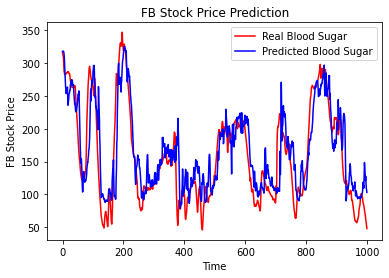

In [38]:
# Visualising the results
plt.plot(y_test[0:1000], color = 'red', label = 'Real Blood Sugar')
plt.plot(predicted_stock_price[0:1000], color = 'blue', label = 'Predicted Blood Sugar')
plt.title('FB Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('FB Stock Price')
plt.legend()
plt.show()

In [39]:
rms = mean_squared_error(y_test, predicted_stock_price, squared=False)

In [40]:
rms

45.42682